# CSE 572: Lab 13

In this lab, you will practice implementing techniques for dimensionality reduction using features extracted by pre-trained neural networks and classification with transfer learning.

To execute and make changes to this notebook, click File > Save a copy to save your own version in your Google Drive or Github. Read the step-by-step instructions below carefully. To execute the code, click on each cell below and press the SHIFT-ENTER keys simultaneously or by clicking the Play button. 

When you finish executing all code/exercises, save your notebook then download a copy (.ipynb file). Submit the following **three** things:
1. a link to your Colab notebook,
2. the .ipynb file, and
3. a pdf of the executed notebook on Canvas.

To generate a pdf of the notebook, click File > Print > Save as PDF.

## Load the dataset

We will use the same “Labeled Faces in the Wild” (LFW) [dataset](http://vis-www.cs.umass.edu/lfw/) that we used in Labs 11 and 12 for this lab. Since we are going to use neural networks pre-trained using the ImageNet database which has RGB color images, we will load in the images in color rather than grayscale format (`color=True`) and keep the original image size (`resize=1.0`).

In [ ]:
from sklearn.datasets import fetch_lfw_people

lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=1.0, color=True)

# data attribute gives the data matrix with the image dimension flattened
X = lfw_people.data
print('Num samples: {}'.format(X.shape[0]))
print('Num features: {}'.format(X.shape[1]))

# images attribute gives the unflattened image dimension
print('Image dimensions: {} x {}'.format(lfw_people.images.shape[1], lfw_people.images.shape[2]))

# the label to predict is the id of the person
y = lfw_people.target
# target_names attribute tells us the name of the person associated with each id
target_names = lfw_people.target_names
n_classes = target_names.shape[0]
print('Num classes: {}'.format(n_classes))
print('Class names:', target_names)

Num samples: 1288
Num features: 35250
Image dimensions: 125 x 94
Num classes: 7
Class names: ['Ariel Sharon' 'Colin Powell' 'Donald Rumsfeld' 'George W Bush'
 'Gerhard Schroeder' 'Hugo Chavez' 'Tony Blair']


The dataset has 1,288 images of the faces of 7 different people. The code below prints the number of samples from each class.

In [ ]:
for i in range(n_classes):
    print('Number of instances in class {} ({}): {}'.format(i,
                                                            target_names[i],
                                                            y[y==i].shape[0]
                                                           ))

Number of instances in class 0 (Ariel Sharon): 77
Number of instances in class 1 (Colin Powell): 236
Number of instances in class 2 (Donald Rumsfeld): 121
Number of instances in class 3 (George W Bush): 530
Number of instances in class 4 (Gerhard Schroeder): 109
Number of instances in class 5 (Hugo Chavez): 71
Number of instances in class 6 (Tony Blair): 144


To get an idea of what is in our dataset, we visualize a random face from each class below. (Note: You can run this cell many times to see different random examples.)

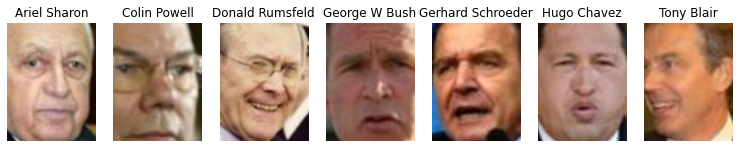

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

fig, axes = plt.subplots(ncols=n_classes, figsize=(13,6))

for i in range(n_classes):
    rand_ind = np.random.randint(0, y[y==i].shape[0])
    axes[i].imshow(lfw_people.images[y==i][rand_ind].astype(np.uint8))
    axes[i].axis('off')
    axes[i].set_title(target_names[i])

Next, we will split the data into training and test subsets, using 30\% of the data for testing.

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

Next we standardize the data so that the mean of all attributes is 0 using the StandardScaler() object in scikit-learn to standardize the data. We fit the scaler to the training data and apply it to both the training and test data.

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## Feature extraction with pre-trained network

One approach for non-linear dimensionality reduction is to extract features using a pre-trained neural network. The network is typically a large architecture that has shown state of the art performance for the pre-training task using a large dataset, in this case ImageNet. We will use the InceptionV3 model pre-trained with ImageNet for our feature extractor. 

Note that we pass the `include_top=False` argument to get the InceptionV3 architecture *without* the final classification layer so that the output will be the last hidden layer of the model.

In [ ]:
import tensorflow as tf

from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input

# Set the random seed for reproducibility
seed = 0
tf.random.set_seed(seed)

In [ ]:
base_model = InceptionV3(weights='imagenet', include_top=False)

base_model.summary()

87910968/87910968 [==============================] - 1s 0us/step
Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv2d (Conv2D)                (None, None, None,   864         ['input_1[0][0]']                
                                32)                                                               
                                                                                                  
 batch_normalization (BatchNorm  (None, None, None,   96         ['conv2d[0][0]']                 
 alization)           

Now that we've loaded the pre-trained InceptionV3 model, we can use it to process the new feature vectors for our LFW dataset. First, we need to reshape the flattend image vector to back into the original image dimensions (125 x 94 x 3).

In [ ]:
# Reshape to be 2D images
X_train_rshp = X_train.reshape([X_train.shape[0], 
                                lfw_people.images.shape[1], 
                                lfw_people.images.shape[2], 
                                lfw_people.images.shape[3]])

X_train_rshp.shape

(901, 125, 94, 3)

Now we input our images through `base_model` to get the feature vector output. Note that we also apply the `preprocess_input()` function to apply the same preprocessing that was used for pre-training the InceptionV3 model.

In [ ]:
X_train_features = base_model.predict(preprocess_input(X_train_rshp))

29/29 [==============================] - 21s 631ms/step


The dimensions of each sample output by the model are 1 x 1 x 2048 (2048 features), so we will reshape these feature vectors to remove the 1x1 dimension. The result is a dataset of 2048-dimensional feature vectors, one for each of our 901 training samples.

In [ ]:
X_train_features.shape

(901, 2, 1, 2048)

In [ ]:
X_train_features = X_train_features[:,0,0]

X_train_features.shape

(901, 2048)

### SVM classifier with InceptionV3 features

Now that we've extracted new features using InceptionV3, we can use these new features as our inputs for classification. In this example, we'll use a Support Vector Machine (SVM) classifier. In the cell below, train an SVM with `C=10000` and `kernel='rbf'` as we did in Labs 11-12.

In [ ]:
# YOUR CODE HERE
from sklearn.svm import SVC
model=SVC(C=10000,kernel="rbf")
model.fit(X_train_features,y_train)

SVC(C=10000)

In the cell(s) below, use the trained model to extract the InceptionV3 feature vectors for the test set. Note that you will have to reshape the test data and the output features in the same way we did for the training data.

In [ ]:
# YOUR CODE HERE
X_test_rshp = X_test.reshape([X_test.shape[0], 
                                lfw_people.images.shape[1], 
                                lfw_people.images.shape[2], 
                                lfw_people.images.shape[3]])

X_test_rshp.shape

(387, 125, 94, 3)

In [ ]:
X_test_features = base_model.predict(preprocess_input(X_test_rshp))

13/13 [==============================] - 8s 582ms/step


In [ ]:
X_test_features = X_test_features[:,0,0]

X_test_features.shape

(387, 2048)

Now that you've extracted the InceptionV3 features for the test dataset, you can use the SVM classifier to make predictions for the test set based on these feature vectors. Do this in the cell below and store your predictions in a variable named `y_pred`.

In [ ]:
# YOUR CODE HERE
y_pred=model.predict(X_test_features)

In [ ]:
y_pred

array([3, 3, 6, 3, 3, 3, 2, 0, 3, 3, 3, 4, 3, 6, 3, 3, 4, 3, 3, 3, 1, 6,
       3, 2, 0, 1, 1, 3, 3, 3, 4, 3, 3, 3, 4, 3, 3, 4, 3, 3, 3, 6, 3, 1,
       1, 1, 3, 3, 1, 3, 3, 3, 2, 3, 3, 2, 1, 3, 6, 3, 1, 1, 1, 4, 3, 0,
       6, 4, 1, 3, 6, 6, 3, 3, 3, 2, 4, 6, 3, 6, 3, 3, 4, 3, 3, 3, 3, 3,
       3, 1, 1, 6, 3, 6, 1, 3, 1, 1, 3, 3, 3, 1, 0, 1, 3, 3, 3, 3, 3, 1,
       0, 1, 3, 3, 3, 6, 3, 3, 1, 3, 1, 3, 3, 0, 3, 3, 6, 3, 1, 1, 6, 6,
       0, 3, 3, 3, 5, 4, 1, 6, 3, 2, 5, 1, 3, 3, 1, 3, 6, 1, 5, 1, 2, 3,
       3, 3, 6, 0, 3, 3, 1, 5, 5, 1, 3, 4, 3, 1, 3, 3, 1, 1, 6, 1, 3, 0,
       3, 2, 2, 3, 3, 3, 4, 3, 4, 3, 3, 3, 4, 2, 3, 2, 3, 2, 6, 4, 3, 6,
       3, 4, 3, 2, 1, 1, 3, 1, 6, 2, 2, 3, 3, 5, 3, 3, 3, 2, 3, 3, 1, 1,
       3, 0, 1, 3, 3, 3, 3, 3, 2, 3, 3, 3, 1, 0, 3, 6, 1, 3, 3, 3, 3, 4,
       6, 6, 3, 0, 3, 1, 3, 1, 3, 3, 3, 1, 3, 3, 3, 1, 6, 3, 3, 3, 3, 3,
       3, 3, 3, 1, 2, 4, 1, 6, 3, 3, 6, 3, 3, 3, 4, 3, 1, 3, 3, 3, 1, 3,
       3, 3, 3, 3, 0, 3, 1, 1, 3, 0, 4, 1, 3, 3, 3,

The next cell shows how we can use the `classification_report()` function in sklearn to print several metrics computed for the test set. 

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred, target_names=target_names))

                   precision    recall  f1-score   support

     Ariel Sharon       0.45      0.56      0.50        18
     Colin Powell       0.75      0.78      0.77        69
  Donald Rumsfeld       0.67      0.53      0.59        34
    George W Bush       0.74      0.88      0.80       166
Gerhard Schroeder       0.35      0.29      0.32        31
      Hugo Chavez       0.71      0.26      0.38        19
       Tony Blair       0.63      0.44      0.52        50

         accuracy                           0.68       387
        macro avg       0.61      0.53      0.55       387
     weighted avg       0.67      0.68      0.67       387



We can also use the `ConfusionMatrixDisplay` object to visualize the confusion matrix for the test set predictions.

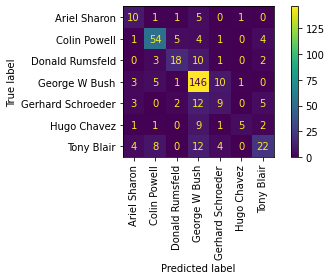

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_estimator(
    model, X_test_features, y_test, display_labels=target_names, xticks_rotation="vertical"
)

plt.tight_layout()
plt.show()

**Question 1: Compare the results from the SVM with InceptionV3 features to the results from KernelPCA in Lab 12 and linear PCA in Lab 11. How do the results differ?**

**Answer:**
This model performs way better than the kernelPCA and Linear PCA. The F1 Scores of this model is better than previous models for all the classes.

## Fine-tune pre-trained network for face classification

One way to increase performance even further is to "fine-tune" the InceptionV3 model for our new classification task by adding a new classification layer to the end of the network and optionally unfreezing some of the later layers in the network.

In the cells below, we load our InceptionV3 pre-trained base model in the same way we did in the first exercise.

In [ ]:
import tensorflow as tf
tf.config.run_functions_eagerly(True)

from tensorflow.keras import layers
from tensorflow.keras import Model

In [ ]:
pre_trained_model = InceptionV3(
    input_shape=(lfw_people.images.shape[1], lfw_people.images.shape[2], 3), include_top=False, weights='imagenet')

For this exercise, we'll freeze all of the layers in the original InceptionV3 model by setting the `trainable` attribute of each layer to `False`. 

In [ ]:
for layer in pre_trained_model.layers:
    layer.trainable = False

We then truncate the pre-trained model at one of the deeper hidden layers and append new layers, including our new classification layer for our LFW face classes, to the end.

In [ ]:
last_layer = pre_trained_model.get_layer('mixed7')

print('last layer output shape:', last_layer.output_shape)

last_output = last_layer.output

last layer output shape: (None, 6, 4, 768)


In [ ]:
# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)

# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)

# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)

# Add a final sigmoid layer for classification
x = layers.Dense(len(target_names), activation='sigmoid')(x)

We now compile the new model.

In [ ]:
# Configure and compile the model
model = Model(pre_trained_model.input, x)
model.compile(loss='categorical_crossentropy',
              optimizer='sgd',
              metrics=['acc'])

Next, we can use our LFW training data and labels to fine-tune the model. Note that first we need to convert our labels to a 1-hot encoding.

In [ ]:
# Convert labels to one-hot encoding
y_train_cat = tf.keras.utils.to_categorical(y_train, num_classes=len(target_names))

In [ ]:
model.fit(x=X_train_rshp, y=y_train_cat,
                epochs=10,
                batch_size=32,
                shuffle=True)

Epoch 1/10


/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


29/29 [==============================] - 112s 4s/step - loss: 2.1992 - acc: 0.4107
Epoch 2/10
29/29 [==============================] - 104s 4s/step - loss: 1.3944 - acc: 0.5161
Epoch 3/10
29/29 [==============================] - 105s 4s/step - loss: 1.3893 - acc: 0.5427
Epoch 4/10
29/29 [==============================] - 112s 4s/step - loss: 1.1151 - acc: 0.6393
Epoch 5/10
29/29 [==============================] - 103s 4s/step - loss: 1.0508 - acc: 0.6448
Epoch 6/10
29/29 [==============================] - 107s 4s/step - loss: 0.9921 - acc: 0.6670
Epoch 7/10
29/29 [==============================] - 105s 4s/step - loss: 0.8925 - acc: 0.7014
Epoch 8/10
29/29 [==============================] - 101s 3s/step - loss: 0.8894 - acc: 0.7192
Epoch 9/10
29/29 [==============================] - 102s 4s/step - loss: 0.8921 - acc: 0.6970
Epoch 10/10
29/29 [==============================] - 102s 4s/step - loss: 0.7364 - acc: 0.7703


Now that we've fine-tuned our model, we can use it to make predictions about our test set. Use the trained model to make predictions for the test dataset in the cell(s) below.

In [ ]:
# YOUR CODE HERE
y_pred=model.predict(X_test_rshp)

13/13 [==============================] - 10s 728ms/step


The `predict()` function returns the class probabilities output by the model for each of the 7 classes. To get the index of the predicted class, we can use the `np.argmax()` function to get the index with the highest class probability.

In [ ]:
y_pred_class = np.argmax(y_pred, axis=1)

Now that we have an array of the predicted classes for the test set, we can compute the performance metrics as in the first exercise. In the cell below, print the classification report for the test set.

In [ ]:
# YOUR CODE HERE
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred_class, target_names=target_names))

                   precision    recall  f1-score   support

     Ariel Sharon       0.13      0.94      0.22        18
     Colin Powell       0.87      0.86      0.86        69
  Donald Rumsfeld       0.91      0.29      0.44        34
    George W Bush       0.86      0.89      0.88       166
Gerhard Schroeder       0.00      0.00      0.00        31
      Hugo Chavez       0.67      0.11      0.18        19
       Tony Blair       0.00      0.00      0.00        50

         accuracy                           0.61       387
        macro avg       0.49      0.44      0.37       387
     weighted avg       0.64      0.61      0.59       387



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


**Question 2: Compare the results from the fine-tuned network to the SVM with InceptionV3 features from the first exercise. How do the results differ?**

**Answer:**

The results of SVM are better overall better than the Fine tuned network. The F1 scores if 5 claases are better for the SVM model and overall accuracy is 7 % better for SVM.

**Question 3: What are some reasons that might explain the difference in performance between the fine-tuned network and the SVM with InceptionV3 features?**

**Answer:**
In the fine tuned model we freeze some layers and train only few layers therefore it doesnt catch all the features. Only the last layers are trained in fine tuning while in SVM it is trained from scratch.
if we unfreeze and make some layers trainable the accuracy might improve in ANN.


